In [1]:
# ! pip install yfinance
# ! pip install MetaTrader5

# https://pypi.org/project/TA-Lib/

In [2]:
import sys
sys.path.append("c:\\users\\alex\\appdata\\roaming\\python\\python38\\site-packages")
sys.path

import mplfinance as mpf

In [70]:
from function.preprocess_function import  *
from function.vizualization import  *

from sklearn.ensemble import RandomForestRegressor

from sklearn.feature_selection import RFE

import warnings
warnings.filterwarnings("ignore")


# data from yfinance

In [194]:
current_datetime = datetime.now()
start_date = '2000-01-01'
end_date = current_datetime.strftime('%Y-%m-%d')
# '^GDAXI'
data = yf.download('EURUSD=X', start= start_date, end=end_date, interval='1d')
data['Volume'] = data['High'] - data['Low']
data['PositivePriceChange'] =  data['High'] -  data['Open'] 
data['NegativePriceChange'] = data['Open'] - data['Low']
# data['PriceDirection'] = np.where(data['PositivePriceChange'] > data['NegativePriceChange'], 'Up', 'Down')



data = data.reset_index()
data['Date'] = pd.to_datetime(data['Date']).dt.strftime('%Y-%m-%d' ) # %H:%M:%S')

data[:50]

[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume,PositivePriceChange,NegativePriceChange
0,2003-12-01,1.203398,1.204007,1.194401,1.196501,1.196501,0.009606,0.000609,0.008998
1,2003-12-02,1.196101,1.210903,1.194600,1.208897,1.208897,0.016303,0.014802,0.001500
2,2003-12-03,1.209000,1.213003,1.207700,1.212298,1.212298,0.005303,0.004004,0.001299
3,2003-12-04,1.212004,1.214403,1.204398,1.208094,1.208094,0.010004,0.002399,0.007605
4,2003-12-05,1.207802,1.219096,1.206593,1.218695,1.218695,0.012503,0.011294,0.001210
5,2003-12-08,1.216797,1.224005,1.215407,1.222001,1.222001,0.008599,0.007208,0.001390
6,2003-12-09,1.222105,1.227702,1.219795,1.224995,1.224995,0.007907,0.005596,0.002311
7,2003-12-10,1.224905,1.226603,1.216205,1.219096,1.219096,0.010398,0.001698,0.008700
8,2003-12-11,1.219096,1.223496,1.212298,1.222404,1.222404,0.011198,0.004400,0.006798
9,2003-12-12,1.222703,1.230603,1.221300,1.227898,1.227898,0.009303,0.007900,0.001404


In [195]:
data.shape

(5169, 9)

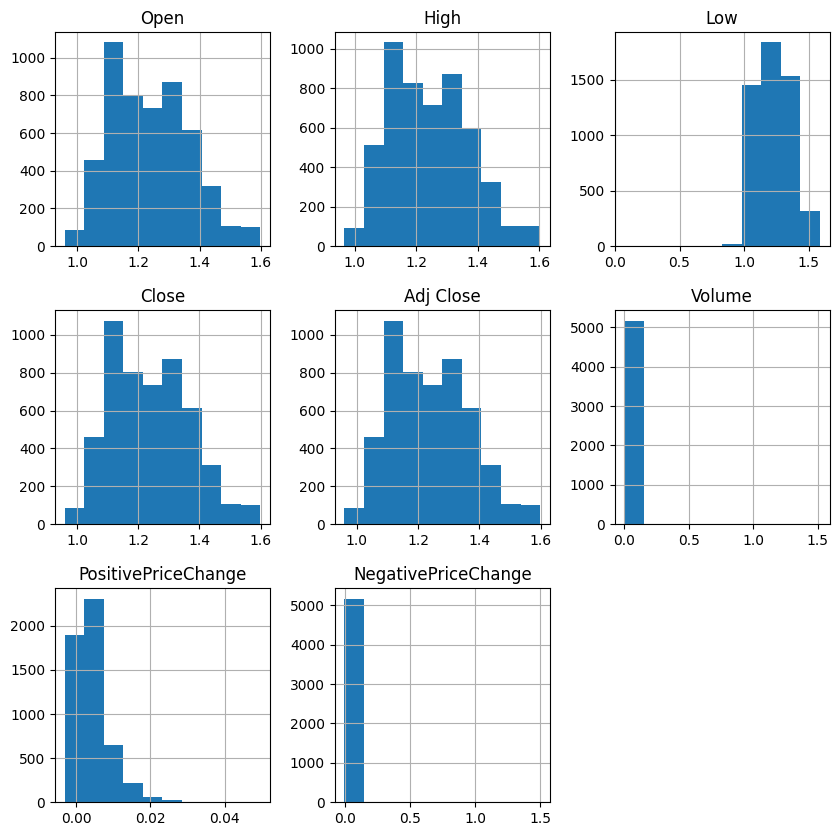

In [196]:
data.hist(figsize = (10,10));

# data preprocessing

In [197]:
# preprocessor = Preprocessing_stock_data(data)
# all_indicator = preprocessor.all_methods()

# data = preprocessor.support_resistance_line()
# data

In [198]:
# all_indicator.sample(3)

# experiments 



Etap I. Określanie kierunku.
1. Wyznaczam cenę max i min dla różnych przedziałów od 1 do 60 dni wstecz.
2. Określam czy cena w bieżącym dniu przekroczyła wyznaczony poziom min lub max.
3. Określam czy cena w bieżącym dniu powróciła do określonego przedziału między min a max.
4. Wyznaczam bieżący kieru5.ek:
- po przekroczeniu i powrocie do poziomu min ("wsparcie") kierunek to6.BUY;
- po przekroczeniu i powrocie do poziomu max ("opór") kierunek to7SELL;
5. Po zakończeniu sesji powtarzam punk
8. Sprawdzam w którym kierunku następnego dnia był większy ruch. W górę to cena max - otwarcie. W dół to cena otwarcie - min.ty 1-4 d

In [199]:
# support_resistance_chart(data) 

In [288]:
def define_level(data: pd.DataFrame, window_sizes: list = [100], bias: int = 1) -> pd.DataFrame:
    data = data.copy()  
    
    for window_size in window_sizes:  
        data.loc[:, f'RollingMax_{window_size}'] = data['High'].rolling(window=window_size).max().shift(bias)
        data.loc[:, f'RollingMin_{window_size}'] = data['Low'].rolling(window=window_size).min().shift(bias)
       
    return data

data_with_breakout_level = define_level(data, [14], 1) #  [i for i in range(14,365,1)])
data_with_breakout_level

,Date,Open,High,Low,Close,Adj Close,Volume,PositivePriceChange,NegativePriceChange,RollingMax_14,RollingMin_14
0,2003-12-01,1.203398,1.204007,1.194401,1.196501,1.196501,0.009606,0.000609,0.008998,NaN,NaN
1,2003-12-02,1.196101,1.210903,1.194600,1.208897,1.208897,0.016303,0.014802,0.001500,NaN,NaN
2,2003-12-03,1.209000,1.213003,1.207700,1.212298,1.212298,0.005303,0.004004,0.001299,NaN,NaN
3,2003-12-04,1.212004,1.214403,1.204398,1.208094,1.208094,0.010004,0.002399,0.007605,NaN,NaN
4,2003-12-05,1.207802,1.219096,1.206593,1.218695,1.218695,0.012503,0.011294,0.001210,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
5164,2023-10-26,1.056725,1.056971,1.052632,1.056725,1.056725,0.004339,0.000246,0.004093,1.06905,1.048394
5165,2023-10-27,1.056446,1.059771,1.053630,1.056446,1.056446,0.006141,0.003325,0.002816,1.06905,1.049615
5166,2023-10-30,1.056245,1.062600,1.054841,1.056245,1.056245,0.007759,0.006355,0.001404,1.06905,1.049615
5167,2023-10-31,1.061504,1.066906,1.056759,1.061504,1.061504,0.010147,0.005402,0.004745,1.06905,1.049615


In [289]:
print(data_with_breakout_level.isna().sum())
data_with_breakout_level.dropna( axis = 0, inplace = True)

Date                    0
Open                    0
High                    0
Low                     0
Close                   0
Adj Close               0
Volume                  0
PositivePriceChange     0
NegativePriceChange     0
RollingMax_14          14
RollingMin_14          14
dtype: int64


In [290]:
data_with_breakout_level.reset_index(drop = True, inplace= True)
data_with_breakout_level# .reset_index(drop = True, inplace= True)


,Date,Open,High,Low,Close,Adj Close,Volume,PositivePriceChange,NegativePriceChange,RollingMax_14,RollingMin_14
0,2003-12-19,1.242205,1.243503,1.235102,1.238497,1.238497,0.008401,0.001297,0.007104,1.244199,1.194401
1,2003-12-22,1.235697,1.244601,1.235697,1.239895,1.239895,0.008905,0.008905,0.000000,1.244199,1.194600
2,2003-12-23,1.239895,1.267202,1.238804,1.240003,1.240003,0.028398,0.027307,0.001091,1.244601,1.204398
3,2003-12-24,1.240095,1.247194,1.240003,1.245299,1.245299,0.007191,0.007099,0.000092,1.267202,1.204398
4,2003-12-25,1.245702,1.247007,1.244307,1.244803,1.244803,0.002700,0.001305,0.001395,1.267202,1.206593
...,...,...,...,...,...,...,...,...,...,...,...
5150,2023-10-26,1.056725,1.056971,1.052632,1.056725,1.056725,0.004339,0.000246,0.004093,1.069050,1.048394
5151,2023-10-27,1.056446,1.059771,1.053630,1.056446,1.056446,0.006141,0.003325,0.002816,1.069050,1.049615
5152,2023-10-30,1.056245,1.062600,1.054841,1.056245,1.056245,0.007759,0.006355,0.001404,1.069050,1.049615
5153,2023-10-31,1.061504,1.066906,1.056759,1.061504,1.061504,0.010147,0.005402,0.004745,1.069050,1.049615


In [298]:
# Analiza odbicia cen od poziomów oporu
data_with_breakout_level['Breakout_from_Resistance'] = ((data_with_breakout_level["RollingMax_14"] < data_with_breakout_level["High"])  & (data_with_breakout_level["RollingMax_14"] > data_with_breakout_level["Close"])).astype(int)
resistance_indices = data_with_breakout_level[data_with_breakout_level['Breakout_from_Resistance'] == True].index + 1
data_with_breakout_level.loc[resistance_indices, 'Next_Resistance_Candle_Type'] = (data_with_breakout_level.loc[resistance_indices, 'Open'] > data_with_breakout_level.loc[resistance_indices, 'Close']).astype(int)

# Analiza odbicia cen od poziomów wsparcia
data_with_breakout_level['Breakout_from_Support'] = ((data_with_breakout_level["RollingMin_14"] > data_with_breakout_level["Low"])  & (data_with_breakout_level["RollingMin_14"] < data_with_breakout_level["Close"])).astype(int)
support_indices = data_with_breakout_level[data_with_breakout_level['Breakout_from_Support'] == True].index + 1
data_with_breakout_level.loc[support_indices, 'Next_Support_Candle_Type'] = (data_with_breakout_level.loc[support_indices, 'Open'] < data_with_breakout_level.loc[support_indices, 'Close']).astype(int)

# Вывод результатов анализа
data_with_breakout_level['Breakout_from_Resistance'].sum(), data_with_breakout_level['Breakout_from_Support'].sum()
# data_with_breakout_level



# # Wyłączenie poprzednich kolumn i dodanie nowych kolumn do analizy przebicia poziomów oporu i wsparcia
# data_with_breakout_level['Przerwa_w_Wsparciu'] = data_with_breakout_level["RollingMin_14"] > data_with_breakout_level["Close"]
# data_with_breakout_level['Przerwa_w_Oporze'] = data_with_breakout_level["RollingMax_14"] < data_with_breakout_level["Close"]

# # Analiza sumy przebiciu poziomów wsparcia i oporu
# data_with_breakout_level['Przerwa_w_Wsparciu'].sum(), data_with_breakout_level['Przerwa_w_Oporze'].sum()

# # Wyświetlenie wierszy, gdzie warunek przebicia poziomu oporu jest spełniony
# data_with_breakout_level[data_with_breakout_level['Przebicie_oporu'] == True]


(499, 525)

[RFE](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html)

In [100]:
def calculate_score(data):
    # Расчет средней прибыльности
    returns = data['Close'].pct_change()  # Вычисление процентного изменения цен закрытия
    average_return = returns.mean()  # Вычисление среднего значения процентного изменения
    return average_return

def optimize_parameters(data, parameter_ranges):
    best_score = 0
    best_params = None

    for window_size in parameter_ranges['window_size']:
        for bias in parameter_ranges['bias']:
            current_data = define_level(data, [window_size], bias)  # Передаем window_size как список
            # Здесь вы можете реализовать другие методы оптимизации, такие как расчет метрики эффективности и сравнение с лучшим результатом
            current_score = calculate_score(current_data)  # Функция для расчета метрики эффективности

            if current_score > best_score:
                best_score = current_score
                best_params = {'window_size': window_size, 'bias': bias}

    return best_params

# Пример использования оптимизации параметров
parameter_ranges = {'window_size': [i for i in range(20, 365, 1)], 
                    'bias': [i for i in range(1, 10, 1)]}

best_parameters = optimize_parameters(data, parameter_ranges)
print(f"Лучшие параметры: {best_parameters}")

Лучшие параметры: {'window_size': 20, 'bias': 1}


# AI

In [ ]:
def create_dataset(dataset, time_step=25):
    dataX, dataY = [], []
    dataset_without_close = dataset.drop('Close', axis=1)

    for i in range(len(dataset) - time_step - 1):
        if (i + time_step) < len(dataset):
            a = dataset_without_close.iloc[i:(i + time_step), :]
            dataX.append(a.values)
            dataY.append(dataset.iloc[i + time_step]['Close'])  # Добавлено изменение в индексации здесь
    return np.array(dataX), np.array(dataY)

In [ ]:
def create_dataset(dataset, time_step):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)